## Домашнее задание 1

### Обучаем LightFM бейзлайн

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv("/Users/n.anokhin/Desktop/train.csv")

data = data[data["time"] > 0.75].copy().reset_index()

data["test"] = np.random.random(len(data)) > 0.8

data.head(10)

,index,user,track,time,test
0,8,4b90453a4a89fdd400cbeb7339c8fe8c,4945,1.0,False
1,27,4b90453a4a89fdd400cbeb7339c8fe8c,14427,1.0,True
2,34,4b90453a4a89fdd400cbeb7339c8fe8c,18078,1.0,False
3,38,4b90453a4a89fdd400cbeb7339c8fe8c,22374,1.0,False
4,55,4b90453a4a89fdd400cbeb7339c8fe8c,37715,1.0,False
5,64,4b90453a4a89fdd400cbeb7339c8fe8c,40528,1.0,True
6,67,4b90453a4a89fdd400cbeb7339c8fe8c,40537,1.0,True
7,71,4b90453a4a89fdd400cbeb7339c8fe8c,44790,0.8,False
8,74,4b90453a4a89fdd400cbeb7339c8fe8c,45270,0.8,False
9,82,4b90453a4a89fdd400cbeb7339c8fe8c,47124,0.8,False


In [3]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

9948

In [4]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 3].index.values)

len(tracks)

22984

In [5]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = data[data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]

len(train_data), len(test_data)

(129597, 27156)

In [6]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [7]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [8]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [9]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.01
}

In [10]:
model, precisions_at = fit_model(
    epochs=150,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0018606710946187377 +/- 0.00029196351756030273
1:	0.0018938975408673286 +/- 0.00029106414433170496
2:	0.0019603499677032232 +/- 0.00029728706478380167
3:	0.0022483111824840307 +/- 0.0003266729424897796
4:	0.002868534764274955 +/- 0.00038196208317063294
5:	0.004020378924906254 +/- 0.00046276712835013623
6:	0.0049617900513112545 +/- 0.0005163698649844748
7:	0.005781371146440506 +/- 0.0005584841301364197
8:	0.006456972099840641 +/- 0.0005894935170440819
9:	0.007265477906912565 +/- 0.0006240501424635461
10:	0.008118285797536373 +/- 0.0006575697905696474
11:	0.008937866427004337 +/- 0.0006854251758236872
12:	0.00972422119230032 +/- 0.0007136367987083126
13:	0.010521652176976204 +/- 0.0007381212200675832
14:	0.011341234669089317 +/- 0.0007613236931112678
15:	0.012016834691166878 +/- 0.0007811081752045492
16:	0.012825341895222664 +/- 0.0008057188473030458
17:	0.013534167781472206 +/- 0.000823402864419612
18:	0.014242995530366898 +/- 0.0008410212588147546
19:	0.015073652379214764 +/- 0.00

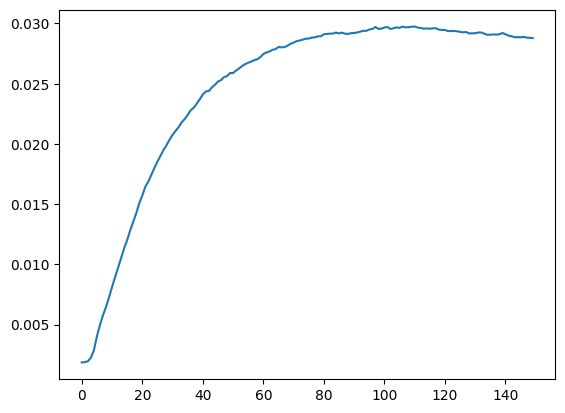

In [11]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

### Готовим данные для сабмита

In [12]:
submit_data = pd.read_csv("/Users/n.anokhin/Desktop/test.csv")
submit_data.head()

,user,track
0,4b90453a4a89fdd400cbeb7339c8fe8c,2262
1,4b90453a4a89fdd400cbeb7339c8fe8c,3864
2,4b90453a4a89fdd400cbeb7339c8fe8c,4467
3,4b90453a4a89fdd400cbeb7339c8fe8c,9616
4,4b90453a4a89fdd400cbeb7339c8fe8c,10675


In [13]:
filtered_submit_data = submit_data[submit_data["user"].isin(users) & submit_data["track"].isin(tracks)].drop_duplicates().copy()

In [14]:
filtered_submit_data["score"] = model.predict(
    filtered_submit_data["user"].map(dataset.mapping()[0]).values,
    filtered_submit_data["track"].map(dataset.mapping()[2]).values,
)

<Axes: xlabel='score', ylabel='Count'>

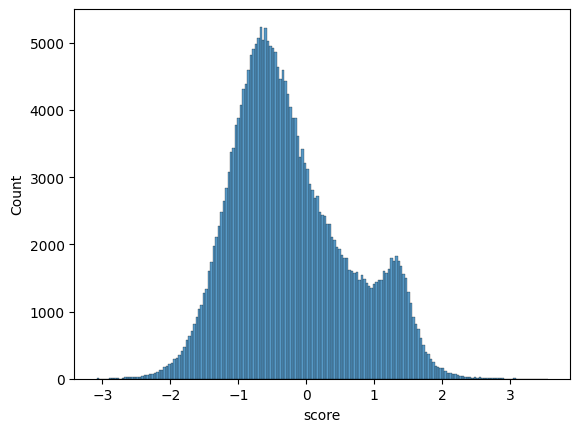

In [15]:
sns.histplot(filtered_submit_data["score"])

In [16]:
scored_submit_data = pd.merge(
    submit_data,
    filtered_submit_data,
    left_on=["user", "track"],
    right_on=["user", "track"],
    how="left"
)

# Fill missing scores with small random numbers
scored_submit_data["score"] = scored_submit_data["score"].map(lambda s : np.random.random() * 0.01 if pd.isna(s) else np.exp(s))
# scored_submit_data["score"] = scored_submit_data["score"].map(lambda s : np.random.random())

scored_submit_data.head()

,user,track,score
0,4b90453a4a89fdd400cbeb7339c8fe8c,2262,0.004059
1,4b90453a4a89fdd400cbeb7339c8fe8c,3864,0.283145
2,4b90453a4a89fdd400cbeb7339c8fe8c,4467,0.412571
3,4b90453a4a89fdd400cbeb7339c8fe8c,9616,0.477830
4,4b90453a4a89fdd400cbeb7339c8fe8c,10675,0.684693


In [17]:
scored_submit_data.to_csv("/Users/n.anokhin/Desktop/submit.csv", index=False)

In [18]:
%%sh 
head /Users/n.anokhin/Desktop/submit.csv

user,track,score
4b90453a4a89fdd400cbeb7339c8fe8c,2262,0.004058763161331291
4b90453a4a89fdd400cbeb7339c8fe8c,3864,0.28314463670595397
4b90453a4a89fdd400cbeb7339c8fe8c,4467,0.4125708105758185
4b90453a4a89fdd400cbeb7339c8fe8c,9616,0.4778302947570418
4b90453a4a89fdd400cbeb7339c8fe8c,10675,0.6846927144838257
4b90453a4a89fdd400cbeb7339c8fe8c,12666,0.37893745233308557
4b90453a4a89fdd400cbeb7339c8fe8c,13335,0.8303565128765577
4b90453a4a89fdd400cbeb7339c8fe8c,15874,0.38635471560226986
4b90453a4a89fdd400cbeb7339c8fe8c,16294,0.38141027541486006
